# Optimal Pricing Strategy

### The optimal price equation

For a given product with features $x$ (among them the cost $c$), let $f(x)$ be a pricing strategy. Let the demand at price $f$ of product $x$ be $D(x, f)$, which corresponds to the probability that the client purchases the product given the features $x$ and the set price $f$.

The expected revenue is $R = \mathbb E[f-c]$, where
$$\mathbb E[f-c] = \int dx (f(x)-c) D(x, f) P(x),$$
where $P(x)$ is the frequency with which a product with features $x$ is offered.

The optimal pricing must fullfill the optimality condition
$$
    \left.\frac{\delta \mathbb E[f-c]}{\delta f}\right|_{f=f^*} = \mathbb E\left[D(x, f^*) + (f^* - c)\left.\frac{\partial D}{\partial f}\right|_{f=f^*}\right] = 0
$$

where $\frac{\partial D}{\partial f}$ is the elasticity of the demand at price $f$.

This results in the **optimal price equation** for a given product with features $x$:
$$
    (f^*-c)\left.\frac{\partial D(x, f)}{\partial f}\right|_{f=f^*}= - D(x, f^*)
$$


This equation has no trivial solution and requires taiolerd numerical methods for each specific demand function $D(x, f)$

Since the optimal price equation is linear in $D$ we can replace the demand by its normalized value, i.e., the probability that a customer purchases the product at given features $x$ and set price $f$, $D(x, f) = P(\textrm{purchase}|x, f)$.

### Modelling demand with a logistic regression

For a logistic regression, this probability can be expressed as
$$
    D(x, f) = \frac{1}{1+\exp(-k^\top\cdot x - z - \gamma f)}
$$
where $x$ is the full set of features (excluding `bag_total_price`), $k$ are the associated model parameters and $z$ is the intercept.  

The elasticity then becomes
$$
    \frac{\partial D(x, f)}{\partial f} = D(x, f)(1-D(x, f))\gamma
$$
and the optimal price equation can be written as
$$
    (f^*(x)-c) (1-D(x, f^*(x)))\gamma + 1 = 0
$$

### Example

Suppose $x$ and $\theta$ are given so that $\theta^\top x = k$ and by measuring money in suitable units we can assume $\gamma=1$. The optimal price equation then becomes
$$
    f^*=c + \frac{e^{-k-f^*}}{1+e^{-k-f^*}}
$$

In [1]:
from src.benchmark import Benchmark
from src.models.baseline import LogisticRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.plots import prob_hist
from scipy.optimize import fsolve
from scipy.special import expit, logit
from matplotlib.colors import Normalize
cmap = plt.colormaps["rainbow"]

import warnings

file_path = 'data/export.parquet'
df = pd.read_parquet(file_path)

# Define features and target variable
X = df.drop(['Bag_Purchased'], axis=1)
y = df['Bag_Purchased']

model = LogisticRegressor()

model.fit(X, y)

y_pred = model.pipeline.predict(X)

y_pred.mean(), model.model.intercept_[0]

/Users/amonras/.pyenv/versions/3.12.2/envs/kiwi/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


(0.09634085213032581, -0.10855901653957076)

In [2]:
theta = pd.Series(model.model_coefficients())
intercept = model.model.intercept_ 

### Explore class imbalance

In [3]:
# Compute contrubutions from other features
X_transf = pd.DataFrame(
    model.pipeline.named_steps['preprocessor'].transform(X),
    columns = model.get_feature_names()
)
theta = pd.Series(model.model_coefficients())

# This is the full set of predictors, including the sell price
KX = X_transf.dot(theta).rename('kx') + intercept

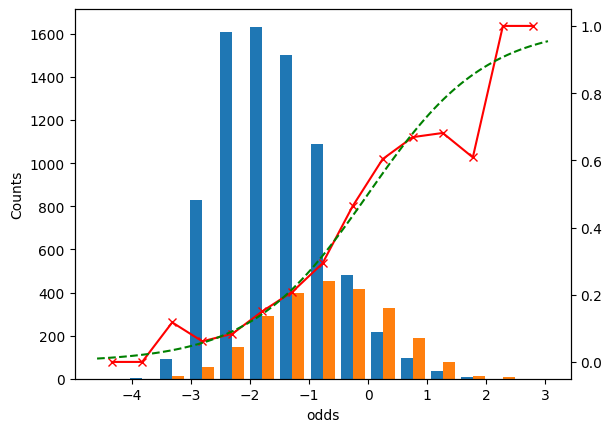

In [4]:
hist = prob_hist(
    predictor=KX,
    target=y,
    nbins=15
)

In [5]:
# What's the predicted demand? (observed demand is 24%)
expit(KX).mean()

0.23926352262474962

## Prepare the optimal price equation

Let's compute the contribution of all features, leaving aside the contribution from the total price. According to our model, the demand function is given by
$$
    D(x, f) = \textrm{expit}(Z + \gamma f)
$$
where we will call $Z=k^\top x + \textrm{intercept}$ **the utility**. 

The cost $c=$ `bag_base_price` should not be a part of the feature vector $x$. It is already filtered out by the pipeline in `X_transf`.

In [6]:
assert 'bag_base_price' not in theta.keys()

In [7]:
cost = X['bag_base_price'].rename('cost')
Z = (X_transf.drop('bag_total_price', axis=1).dot(theta.drop('bag_total_price')) + intercept).rename('kx')
gamma = theta['bag_total_price']

gamma

-0.026134070295815152

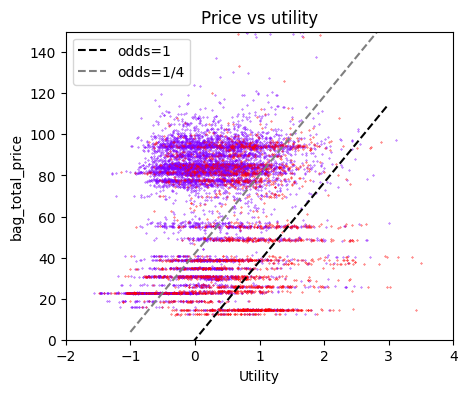

In [8]:
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(Z[~y], X_transf['bag_total_price'][~y], s=.1, color=cmap(0))
plt.scatter(Z[y], X_transf['bag_total_price'][y], s=.1, color='red')
ax.set_xlabel('Utility')
ax.set_ylabel('bag_total_price')
ax.plot(np.array([-1, 3]), -np.array([-1, 3])/gamma, 'k--', label='odds=1')
ax.plot(np.array([-1, 3]), (logit(.25) - np.array([-1, 3]))/gamma, color = 'tab:gray', ls='--', label='odds=1/4')
ax.set_title('Price vs utility')
ax.set_xlim([-2, 4])
ax.set_ylim([0, 150])
ax.legend()

In [9]:
def optimal_price_equation(f, c, z, g):
    return g * (f - c) * (1 - expit(z + g * f)) + 1
    
def optimize(cost, Z):
    return fsolve(optimal_price_equation, x0=1.5 * cost, args=(cost, Z, gamma))[0]

In [77]:
# warnings.filterwarnings('ignore', 'The iteration is not making good progress')

optimal_price = pd.concat([cost, Z], axis=1).apply(
    lambda row: optimize(row['cost'], row['kx']),
    axis=1
).rename('optimal_price')

results = pd.concat([
    X[['bag_base_price', 'bag_total_price', 'price']], 
    y, 
    optimal_price
], axis=1)

# Add the success probability at optimal price
results['prob'] = expit(Z + gamma * results['optimal_price'])

# Add expected revenue
results['exp_revenue'] = (results['optimal_price'] - results['bag_base_price'])*results['prob']
results['actual_revenue'] = (results['bag_total_price'] - results['bag_base_price'])*results['Bag_Purchased']
results.sample(8)

,bag_base_price,bag_total_price,price,Bag_Purchased,optimal_price,prob,exp_revenue,actual_revenue
376,32.349998,54.994999,18.32,False,74.486186,0.091892,3.871961,0.000000
3691,56.529999,96.100998,324.85,False,99.102866,0.101206,4.308641,0.000000
9417,45.830002,77.911003,112.70,False,86.836260,0.066869,2.742031,0.000000
3131,45.470001,77.299004,143.81,False,89.211173,0.125213,5.476945,0.000000
1948,18.200001,30.940002,35.25,True,65.588867,0.192548,9.124639,12.740002
198,48.080002,81.736008,96.02,False,93.338417,0.154539,6.994188,0.000000
6432,32.290001,54.893002,18.47,False,79.283074,0.185748,8.728846,0.000000
7011,22.690001,38.573002,93.66,True,65.608527,0.108445,4.654299,15.883001


In [78]:
results.mean()

bag_base_price      38.009509
bag_total_price     64.616167
price              106.072021
Bag_Purchased        0.238997
optimal_price       83.651846
prob                 0.151489
exp_revenue          7.378110
actual_revenue       4.949967
dtype: float64

### Explore results

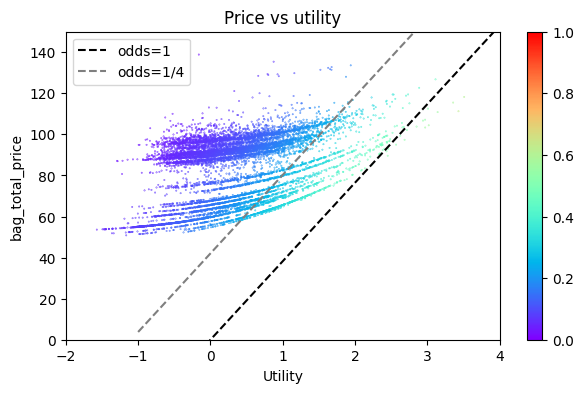

In [79]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.scatter(Z, results['optimal_price'], s=.1, color=cmap(results['prob']))
ax.set_xlabel('Utility')
ax.set_ylabel('bag_total_price')
ax.plot(np.array([-1, 5]), -np.array([-1, 5])/gamma, 'k--', label='odds=1')
ax.plot(np.array([-1, 5]), (logit(.25) - np.array([-1, 5]))/gamma, color = 'tab:gray', ls='--', label='odds=1/4')
ax.set_title('Price vs utility')
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
ax.set_xlim([-2, 4])
ax.set_ylim([0, 150])
ax.legend()

In [80]:
cmap = plt.colormaps["rainbow"]

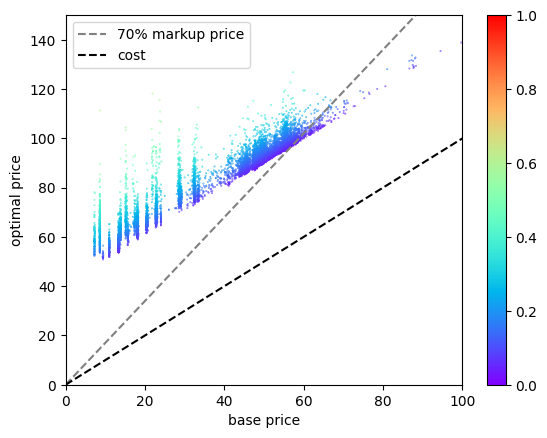

In [81]:
fig, ax = plt.subplots()
ax.scatter(results['bag_base_price'], results['optimal_price'], s=.1, color=cmap(results['prob']))
ax.set_xlabel('base price')
ax.set_ylabel('optimal price')
line = np.array([0, 150])
ax.plot(line, 1.7 * line, c='gray', ls='--', label='70% markup price')
ax.plot(line, line, 'k--', label='cost')
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)

ax.set_xlim([0, 100])
ax.set_ylim([0, 150])
ax.legend()

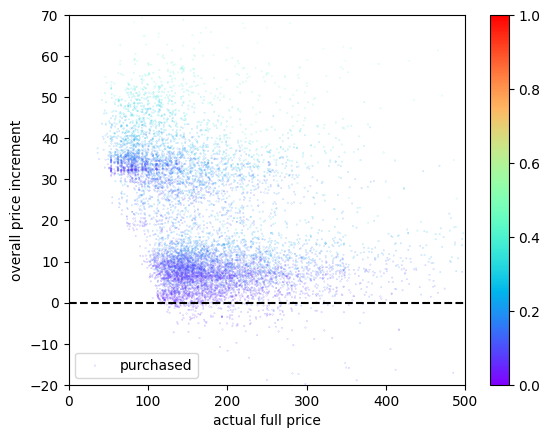

In [82]:
fig, ax = plt.subplots()

x = results['price'] + results['bag_total_price']

ax.scatter(x, results['price'] + results['optimal_price'] - x, label='purchased', s=.01, c=cmap(results['prob']))
# ax.scatter(x[~y], results['price'][~y] + results['optimal_price'][~y] - x[~y], label='not purchased', s=.01)
ax.set_xlabel('actual full price')
ax.set_ylabel('overall price increment')
ax.plot([0, 600], [0, 0], 'k--')
ax.set_xlim([0, 500])
ax.set_ylim([-20, 70])
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
ax.legend()

## Risk analysis

In [83]:
results

,bag_base_price,bag_total_price,price,Bag_Purchased,optimal_price,prob,exp_revenue,actual_revenue
0,18.219999,30.973999,61.31,True,59.362141,0.069951,2.877914,12.754000
1,57.990002,98.583008,86.96,True,98.653907,0.059012,2.399678,40.593006
2,34.840000,59.228001,56.60,False,78.370292,0.120975,5.266065,0.000000
3,13.360000,22.712000,53.09,False,55.499174,0.091956,3.874947,0.000000
4,45.380001,77.146004,50.92,False,91.599535,0.172120,7.955307,0.000000
...,...,...,...,...,...,...,...,...
9970,32.470001,55.199005,42.67,False,74.131683,0.081549,3.397455,0.000000
9971,49.900002,84.830002,91.49,False,91.214177,0.073823,3.049948,0.000000
9972,58.310001,99.127007,152.37,False,101.326590,0.110477,4.752362,0.000000
9973,55.250000,93.925003,151.74,False,96.630999,0.075319,3.116772,0.000000


In [84]:
results['variance'] = results['prob']*(1 - results['prob'])

summary = results.mean()
summary['std'] = np.sqrt(summary['variance'])
summary['exp_revenue']
summary

print(f"Expected revenue per flight is going to be {summary['exp_revenue']:.2f}€ +/- {summary['std']:.2f}€")
print(f"Total expected revenue in the period is going to be {summary['exp_revenue']*len(results):.0f}€ +/- {summary['std']*len(results):.0f}€")
print(f"68% (1-sigma) Confidence interval is [{(summary['exp_revenue'] - summary['std'])*len(results):.0f}€, {(summary['exp_revenue'] + summary['std'])*len(results):.0f}€]")
print(f"95% (2-sigma) Confidence interval is [{(summary['exp_revenue'] - 2*summary['std'])*len(results):.0f}€, {(summary['exp_revenue'] + 2*summary['std'])*len(results):.0f}€]")

Expected revenue per flight is going to be 7.38€ +/- 0.35€
Total expected revenue in the period is going to be 73597€ +/- 3474€
68% (1-sigma) Confidence interval is [70123€, 77071€]
95% (2-sigma) Confidence interval is [66649€, 80545€]


### Use bootstrap to confirm volatility estimates

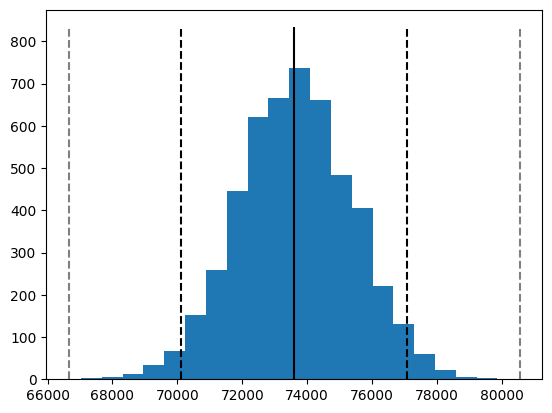

In [85]:
rev = []
N = 5000

for i in range(N):
    sample = results.sample(len(results), replace=True)                            
    purchased = sample['prob'] > np.random.sample(sample.shape[0])
    revenue = (sample['optimal_price'] - sample['bag_base_price']) * purchased
    rev.append(revenue.sum())

fig = plt.hist(rev, bins=20)
plt.vlines(summary['exp_revenue']*len(results), ymin=0, ymax=N/6, colors='black')
plt.vlines((summary['exp_revenue'] + summary['std'])*len(results), ymin=0, ymax=N/6, colors='black', linestyles='--')
plt.vlines((summary['exp_revenue'] - summary['std'])*len(results), ymin=0, ymax=N/6, colors='black', linestyles='--')
plt.vlines((summary['exp_revenue'] + 2 * summary['std'])*len(results), ymin=0, ymax=N/6, colors='gray', linestyles='--')
plt.vlines((summary['exp_revenue'] - 2 * summary['std'])*len(results), ymin=0, ymax=N/6, colors='gray', linestyles='--')

### Volume projections

In [86]:
results.mean()

bag_base_price      38.009509
bag_total_price     64.616167
price              106.072021
Bag_Purchased        0.238997
optimal_price       83.651846
prob                 0.151489
exp_revenue          7.378110
actual_revenue       4.949967
variance             0.121289
dtype: float64

We see that the total number of bags purchased would drop from 24% to 15%. Perhaps this is unacceptable

### Constrained optimization formulation

We need to maximize the profit subject to keeping the demand above a certain threshold

$$
\begin{align}
    & \textrm{maximize}_{f(x)} & &\mathbb{E}\left[(f(x) - c) D(x, f(x)\right]\\
    & \textrm{subject~to} & & \mathbb{E}\left[D(x, f(x))\right] > k
\end{align}
$$

The Lagrangean for this optimization is
$$
\begin{align}
    L[f, \lambda] = \mathbb{E}\left[(c-f(x) - \lambda) D(x, f(x)\right] + \lambda k
\end{align}
$$


In [87]:
k = results['Bag_Purchased'].mean()

In [88]:
import numpy as np
from scipy.optimize import minimize


In [199]:
# Define the Lagrangian

# Function to be minimized
def L(f):
    # The array of probabilities
    prob = expit(Z + gamma * f(Z, cost))

    # The constraint. Should be negative
    constraint = (k - prob.mean()) 

    # The objective function with an exponential penalty
    out = ((cost - f(Z, cost)) * prob).mean() + np.exp(100 * constraint)
    return out

# Define a quadratic function f(z, cost)
def func(z, cost, a, b, c, d, e, f):
    return a*z**2 + b * z * cost + c * cost** 2 + d * z + e * cost + f

# Define the objective
def objective(params):
    a, b, c, d, e, f = params
    return L(lambda z, cost: func(z, cost, a, b, c, d, e, f))

# Initial guess for the parameters a, b, c, d, e, f
initial_guess = [1/np.power(Z, 2).mean(), 1/(Z * cost).mean(), 1/np.power(cost, 2).mean(), 1/Z.mean(), 1/cost.mean(), .1]

# Call the minimize function
res = minimize(objective, initial_guess, method='Nelder-Mead')

initial_guess = res.x

# Call the minimize function
res = minimize(objective, initial_guess)

In [200]:
res

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: -5.354686211403066
        x: [ 2.611e+00 -1.371e-01  1.800e-03  1.304e+01  6.587e-01
             2.524e+01]
      nit: 45
      jac: [ 2.384e-07  9.835e-06  8.348e-04  1.788e-07  1.848e-05
             6.557e-07]
 hess_inv: [[ 1.514e+02 -2.713e+00 ... -3.417e+01  4.301e+02]
            [-2.713e+00  3.103e+00 ... -1.147e+01  2.040e+02]
            ...
            [-3.417e+01 -1.147e+01 ...  5.942e+01 -9.887e+02]
            [ 4.301e+02  2.040e+02 ... -9.887e+02  1.695e+04]]
     nfev: 420
     njev: 60

In [201]:
F = lambda z, cost: func(z, cost, *res.x)

In [202]:
optimal_constrained_price = F(Z, cost).rename('optimal_constrained_price')

In [203]:
constr_results = pd.concat([
    results, 
    optimal_constrained_price
], axis=1)

In [204]:


# Add the success probability at optimal price
constr_results['constr_prob'] = expit(Z + gamma * constr_results['optimal_constrained_price'])

# Add expected revenue
constr_results['constr_exp_revenue'] = (constr_results['optimal_constrained_price'] - constr_results['bag_base_price'])*constr_results['constr_prob']
constr_results.sample(8)

,bag_base_price,bag_total_price,price,Bag_Purchased,optimal_price,prob,exp_revenue,actual_revenue,variance,optimal_constrained_price,constr_prob,constr_exp_revenue
8885,45.930000,78.081001,151.56,False,87.560900,0.080870,3.366673,0.000000,0.074330,58.384529,0.158679,1.976267
1828,13.290000,22.593000,70.43,False,57.489234,0.134279,5.935007,0.000000,0.116248,30.598542,0.238507,4.128203
5380,13.300000,22.610001,56.87,True,56.230259,0.108689,4.666032,9.310000,0.096875,28.250005,0.202141,3.022004
592,60.360001,102.612007,122.56,False,102.128476,0.083897,3.504248,0.000000,0.076858,73.087349,0.163615,2.082379
894,49.939999,84.898003,60.74,False,91.049754,0.069218,2.845528,0.000000,0.064427,61.392171,0.138991,1.591752
7542,49.180000,83.606003,212.47,False,91.338098,0.092364,3.893871,0.000000,0.083833,62.657406,0.177180,2.387932
1815,47.939999,81.498001,113.97,True,88.673999,0.060632,2.469774,33.558002,0.056956,58.686243,0.123826,1.330665
7474,50.139999,85.237999,56.62,False,98.112044,0.202364,9.707817,0.000000,0.161413,73.858314,0.323500,7.672865


In [205]:
constr_results.mean()

bag_base_price                38.009509
bag_total_price               64.616167
price                        106.072021
Bag_Purchased                  0.238997
optimal_price                 83.651846
prob                           0.151489
exp_revenue                    7.378110
actual_revenue                 4.949967
variance                       0.121289
optimal_constrained_price     57.262908
constr_prob                    0.250105
constr_exp_revenue             5.684013
dtype: float64

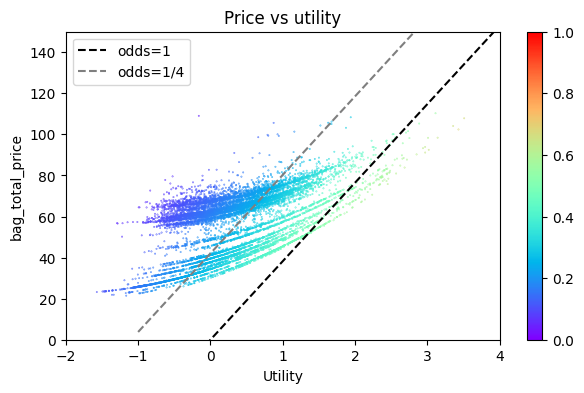

In [206]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.scatter(Z, constr_results['optimal_constrained_price'], s=.1, color=cmap(constr_results['constr_prob']))
ax.set_xlabel('Utility')
ax.set_ylabel('bag_total_price')
ax.plot(np.array([-1, 5]), -np.array([-1, 5])/gamma, 'k--', label='odds=1')
ax.plot(np.array([-1, 5]), (logit(.25) - np.array([-1, 5]))/gamma, color = 'tab:gray', ls='--', label='odds=1/4')
ax.set_title('Price vs utility')
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)
ax.set_xlim([-2, 4])
ax.set_ylim([0, 150])
ax.legend()

In [207]:
cmap = plt.colormaps["rainbow"]

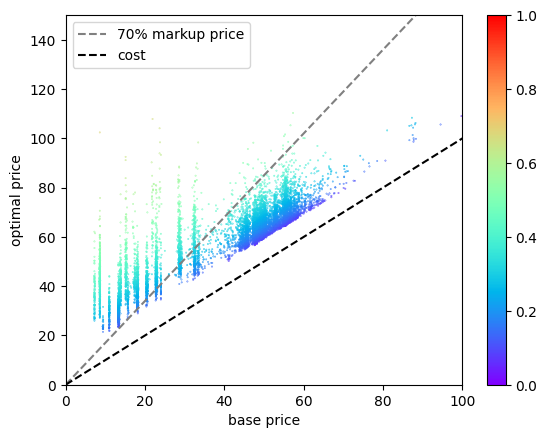

In [208]:
fig, ax = plt.subplots()
ax.scatter(constr_results['bag_base_price'], constr_results['optimal_constrained_price'], s=.1, color=cmap(constr_results['constr_prob']))
ax.set_xlabel('base price')
ax.set_ylabel('optimal price')
line = np.array([0, 150])
ax.plot(line, 1.7 * line, c='gray', ls='--', label='70% markup price')
ax.plot(line, line, 'k--', label='cost')
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)

ax.set_xlim([0, 100])
ax.set_ylim([0, 150])
ax.legend()

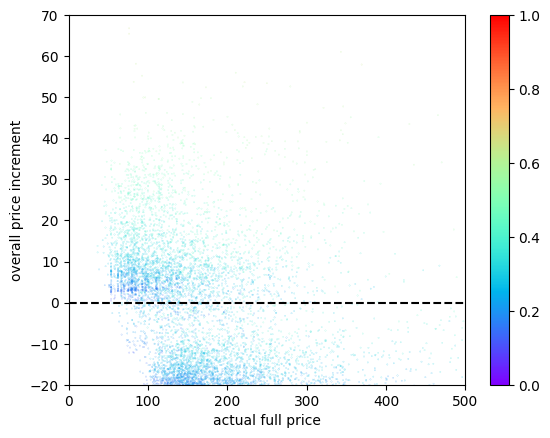

In [209]:
from matplotlib.colors import Normalize

fig, ax = plt.subplots()
cmap = plt.colormaps["rainbow"]

x = constr_results['price'] + constr_results['bag_total_price']

ax.scatter(x, constr_results['price'] + constr_results['optimal_constrained_price'] - x, label='purchased', s=.01, c=cmap(constr_results['constr_prob']))
ax.set_xlabel('actual full price')
ax.set_ylabel('overall price increment')
ax.plot([0, 600], [0, 0], 'k--')
ax.set_xlim([0, 500])
ax.set_ylim([-20, 70])
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, 1), cmap=cmap), ax=ax)


## Use duality

In [ ]:
# Find optimal lambda for a given f

def optimize_slack(f):
    # Find the optimal value for the slack variable
    # return argmax_lambda L[f, lambda]

    # If the constrained is not satisfied the optimization returns infinite
    if expit(Z + gamma * f(Z, cost)).mean() < k:
        return np.inf

    # Define the objective
    def objective(lamb):
        return -L(f, lamb[0])
    
    # Optimize for lambda
    res = minimize(objective, [.1], bounds=[(0, np.inf)])

    val = -objective(res.x)
    
    print(f"The Lagrangian is maximized at lambda={res.x[0]:.4f} with value {val:.4f}")

    return val

# As an example:

def f(z, cost):
    return z**2 - 8*z + 72 - cost

optimize_slack(f)

The Lagrangian is maximized at lambda=0.0000 with value 6.6451


6.64508420265927

In [146]:
# Find the optimal f(Z) that minimizes the Lagrangian sup_lambda L[f(x), lambda]

# Define a quadratic function f(z, cost)
def func(z, cost, a, b, c, d, e, f):
    return a*z**2 + b * z * cost + c * cost** 2 + d * z + e * cost + f

# Define the objective function to minimize (sum of squared residuals)
def objective(params):
    a, b, c, d, e, f = params
    def F(z, cost):
        return func(z, cost, a, b, c, d, e, f)
    lamb = optimize_slack(F)
    return L(F, lamb)

# Initial guess for the parameters a, b, c, d, e, f
initial_guess = [0, 0, 0, 0, .1, .1]

# Call the minimize function
res = minimize(objective, initial_guess)

# Print the result
print(f"The optimal function has parameters {res.x}")
print(res)
objective(res.x)

The Lagrangian is maximized at lambda=0.0000 with value 21.8843
The Lagrangian is maximized at lambda=0.0000 with value 21.8843
The Lagrangian is maximized at lambda=0.0000 with value 21.8843
The Lagrangian is maximized at lambda=0.0000 with value 21.8843
The Lagrangian is maximized at lambda=0.0000 with value 21.8843
The Lagrangian is maximized at lambda=0.0000 with value 21.8843
The Lagrangian is maximized at lambda=0.0000 with value 21.8843


/var/folders/5m/vqkd2l0j2k916b0c3f6bfl4h0000gp/T/ipykernel_10859/2935067177.py:4: RuntimeWarning: invalid value encountered in scalar add
  out = ((cost - f(Z, cost) - lamb) * expit(Z + gamma * f(Z, cost))).mean() + lamb * k
/var/folders/5m/vqkd2l0j2k916b0c3f6bfl4h0000gp/T/ipykernel_10859/2935067177.py:4: RuntimeWarning: invalid value encountered in scalar add
  out = ((cost - f(Z, cost) - lamb) * expit(Z + gamma * f(Z, cost))).mean() + lamb * k


The optimal function has parameters [3.62833449e-01 1.05690993e+01 1.03395704e+03 2.61136422e-01
 2.17491193e+01 6.27200774e-01]
  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: nan
        x: [ 3.628e-01  1.057e+01  1.034e+03  2.611e-01  2.175e+01
             6.272e-01]
      nit: 1
      jac: [       nan        nan        nan        nan        nan
                   nan]
 hess_inv: [[1 0 ... 0 0]
            [0 1 ... 0 0]
            ...
            [0 0 ... 1 0]
            [0 0 ... 0 1]]
     nfev: 784
     njev: 112


nan